# User Intent Classification

## 🔍 Why Use Intent Classification in RAG Systems

User intent classification plays a key role in improving the quality of **Retrieval-Augmented Generation (RAG)** systems. 

It helps ensure that the right documents are retrieved before passing them to a language model.

### ✅ Benefits

- **🎯 Improves Retrieval Relevance**  
  Filters documents based on intent, reducing irrelevant chunks retrieved.

- **🔍 Enables Intent-Based Indexing**  
  Documents are organized by intent category (e.g., `apply_visa`, `track_application`), making search more efficient.

- **🧠 Builds Better Prompts for Generation**  
  Structured prompts based on intent guide the LLM to generate focused answers.

- **🔄 Combines with Semantic Search**  
  Intent narrows down candidate documents before applying vector similarity.

- **📊 Enables Analytics & Personalization**  
  Intent tracking helps tailor responses and refine knowledge coverage.

## 🏃Training the User Intent Classification Model

### 📚 Dataset

In [1]:
DATASET_URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR1hUlRhTJQgNzSbTyRtDNh1mCrbfy0iUm6oiHK7oHb_iQQ5t7XCB_xyUCwoZ2fdg/pub?output=xlsx'
SHEET_NAME = 'shiela'

In [2]:
import pandas as pd


df = pd.read_excel(DATASET_URL, sheet_name=SHEET_NAME)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   query                          2000 non-null   object 
 1   intent                         2000 non-null   object 
 2   your ref ->                    0 non-null      float64
 3   intent.1                       0 non-null      float64
 4   japan_visiting_relatives_visa  0 non-null      float64
 5   current total                  0 non-null      float64
 6   232                            0 non-null      float64
 7   must be                        0 non-null      float64
 8   231.7073171                    18 non-null     object 
 9   items                          0 non-null      float64
dtypes: float64(7), object(3)
memory usage: 156.4+ KB


In [4]:
df['intent'].value_counts()

intent
japan_visiting_relatives_visa      232
japan_tourist_visa                 232
japan_multiple_visa                220
general_japan_visa_requirements    220
japan_visa_fees                    220
japan_visa_processing              195
japan_coe_visa                     195
japan_visa_status                  122
japan_business_conference_visa      73
japan_visiting_military_visa        73
japan_tourist_package_tour          49
japan_nikkeijin_visa                49
japan_spouse_child_visa             24
japan_transit_visa                  24
japan_jfc_visa                      24
japan_housekeeper_visa              24
japan_official_visa                 24
Name: count, dtype: int64

### 🧹 Preprocessing

In [5]:
import stopwordsiso as stopwords

tagalog_stopwords = stopwords.stopwords('tl')

In [6]:
additional_tagalog_stopwords = [
    'po',
    'pong'
    'ba',
    'lang',  
    'bang'
]
for tl_stopword in additional_tagalog_stopwords:
    tagalog_stopwords.add(tl_stopword)

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

# 🔧 One-time setup (only the first time)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(tagalog_stopwords)


# 🧠 Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove special characters, numbers, punctuations (keep letters and space)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Tokenize
    tokens = nltk.word_tokenize(text)

    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 7. Join back to string
    return ' '.join(tokens)



class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # load your model or API key
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # return embedding vectors
        return [clean_text(text) for text in X]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 🧠 Training

In [8]:
X = df['query']
y = df['intent']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


#### 🔘 Option 1: TF-IDF + Logistic Regression Pipeline

In [11]:
models = {}

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_pipeline = Pipeline([
    ('preprocess', Preprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

In [13]:
tfidf_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('vectorizer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [14]:
models['TF-IDF + Logistic'] = tfidf_pipeline

#### 🔘 Option 2: Embeddings + Logistic Regression Pipeline

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np


class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='intfloat/multilingual-e5-base'):
        # Load a multilingual embedding model from HuggingFace Model Hub
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(self.model.encode(X, convert_to_numpy=True))


embeddings_pipeline = Pipeline([
    ('preprocess', Preprocessor()),
    ('embedder', EmbeddingTransformer()),
    ('classifier', LogisticRegression())
])

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
embeddings_pipeline.fit(X_train, y_train)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,steps,"[('preprocess', ...), ('embedder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,model_name,'intfloat/multilingual-e5-base'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [17]:
models['Multilingual-E5-base + Logistic'] = embeddings_pipeline

### 📊 Evaluation

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


def evaluate(models, X_test, y_test):

    metrics = ['precision', 'recall', 'f1-score']
    labels = sorted(list(set(y_test)))  # class labels

    # 📊 Store results
    all_reports = []

    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        df = pd.DataFrame(report).transpose()
        df = df.loc[labels, metrics]  # Only class rows
        df['model'] = model_name
        df['class'] = df.index
        all_reports.append(df)

    # 🧩 Combine all reports into one DataFrame
    combined_df = pd.concat(all_reports)
    
    def plot_results(combined_df, metric):
        # Plot
        g = sns.catplot(
            data=combined_df,
            kind='bar',
            x='class',
            y=metric,
            hue='model',
            height=6,
            aspect=2
        )

        # Access the underlying axes
        ax = g.axes[0][0]

        # Add baseline at 85%
        ax.axhline(0.85, color='red', linestyle='--', linewidth=1.5, label='Baseline 85%')

        # Title and labels
        ax.set_title(f'{metric} per Class by Model')
        ax.set_ylabel(metric)
        ax.set_xlabel('User Intent')
        ax.set_ylim(0, 1)
        ax.grid(axis='y')
        plt.xticks(rotation=90)

        # Optional: Add legend entry for the baseline
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, title='Model', loc='upper right')

        # Show plot
        # plt.tight_layout()
        plt.show()
    
    for metric in metrics:
        plot_results(combined_df, metric)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

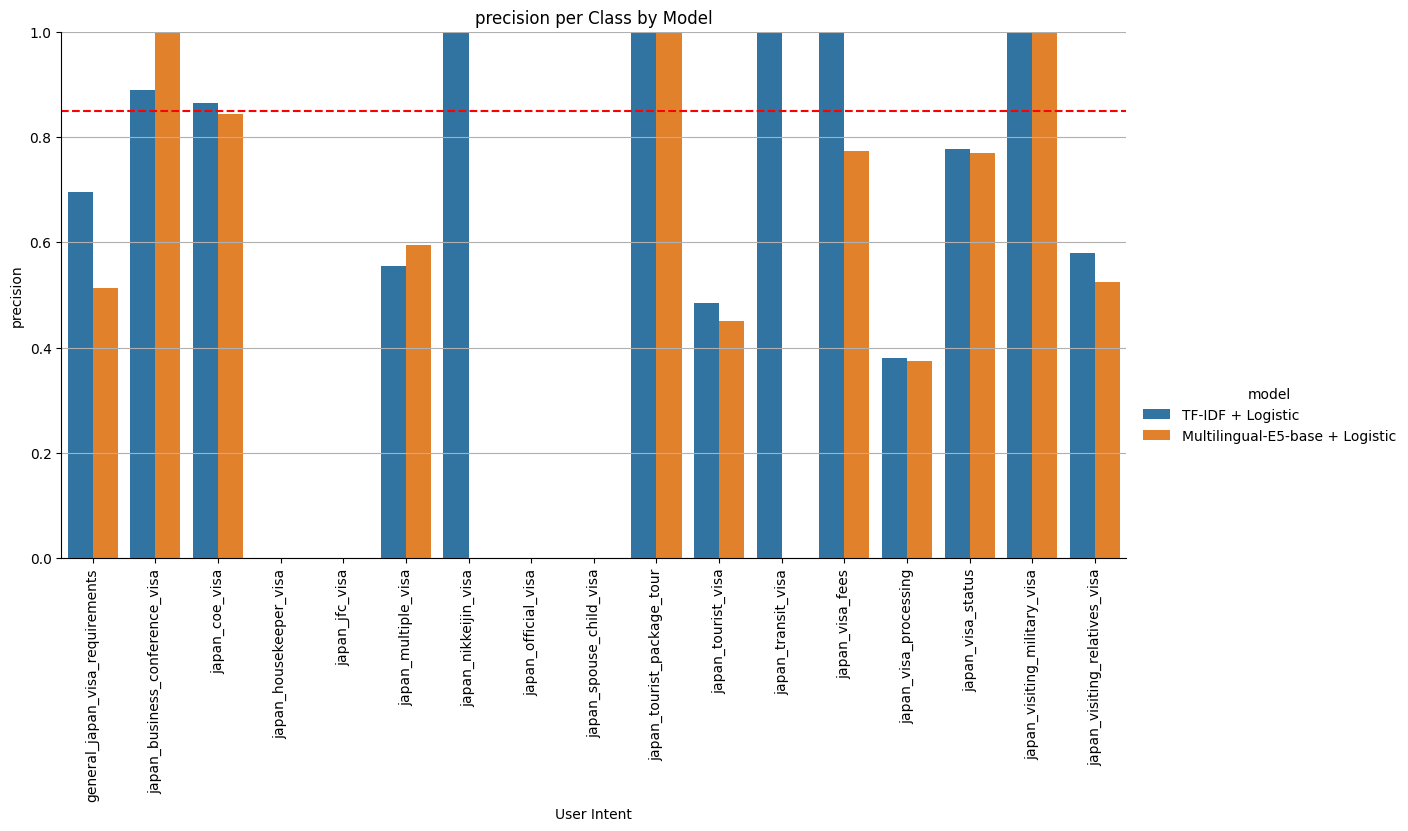

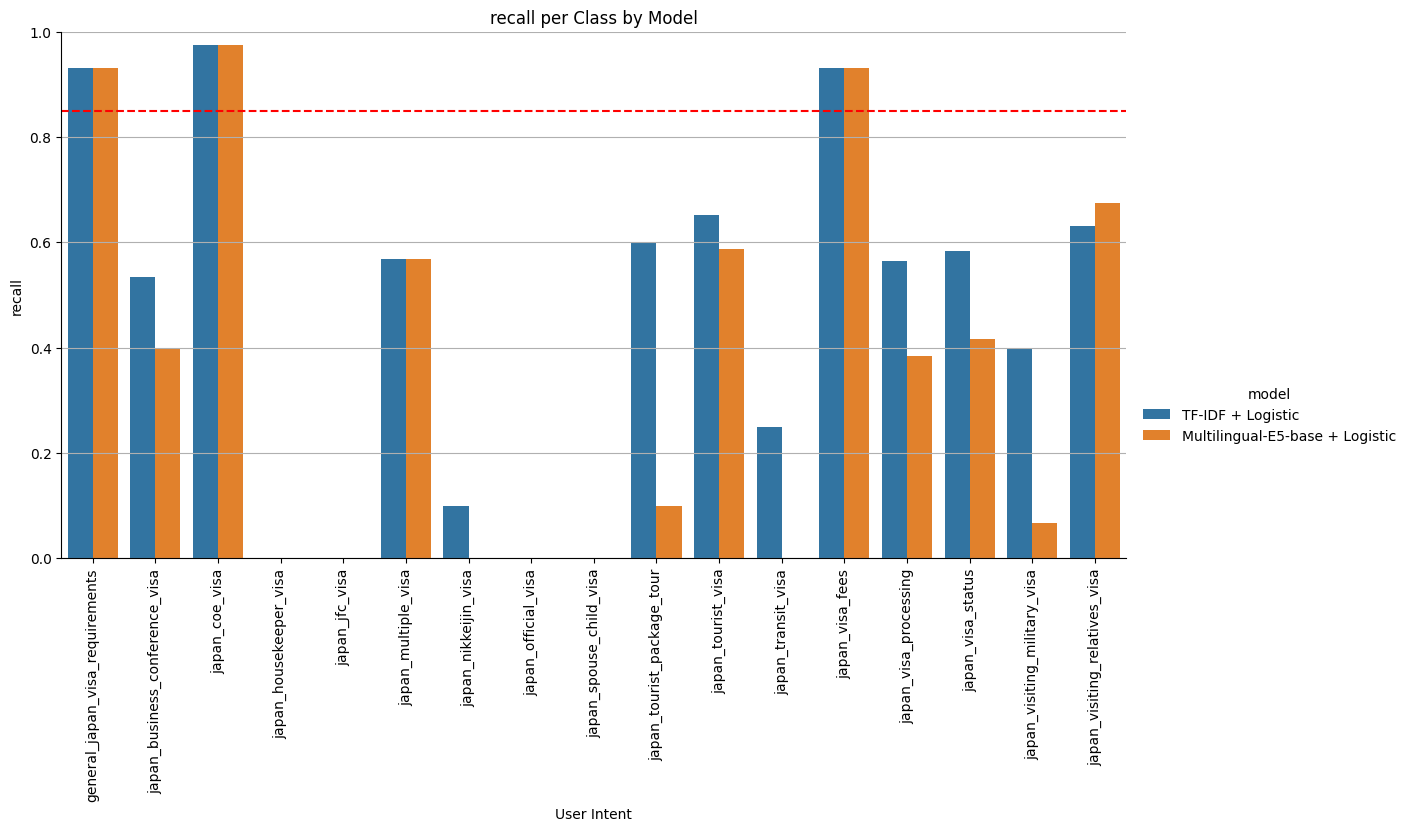

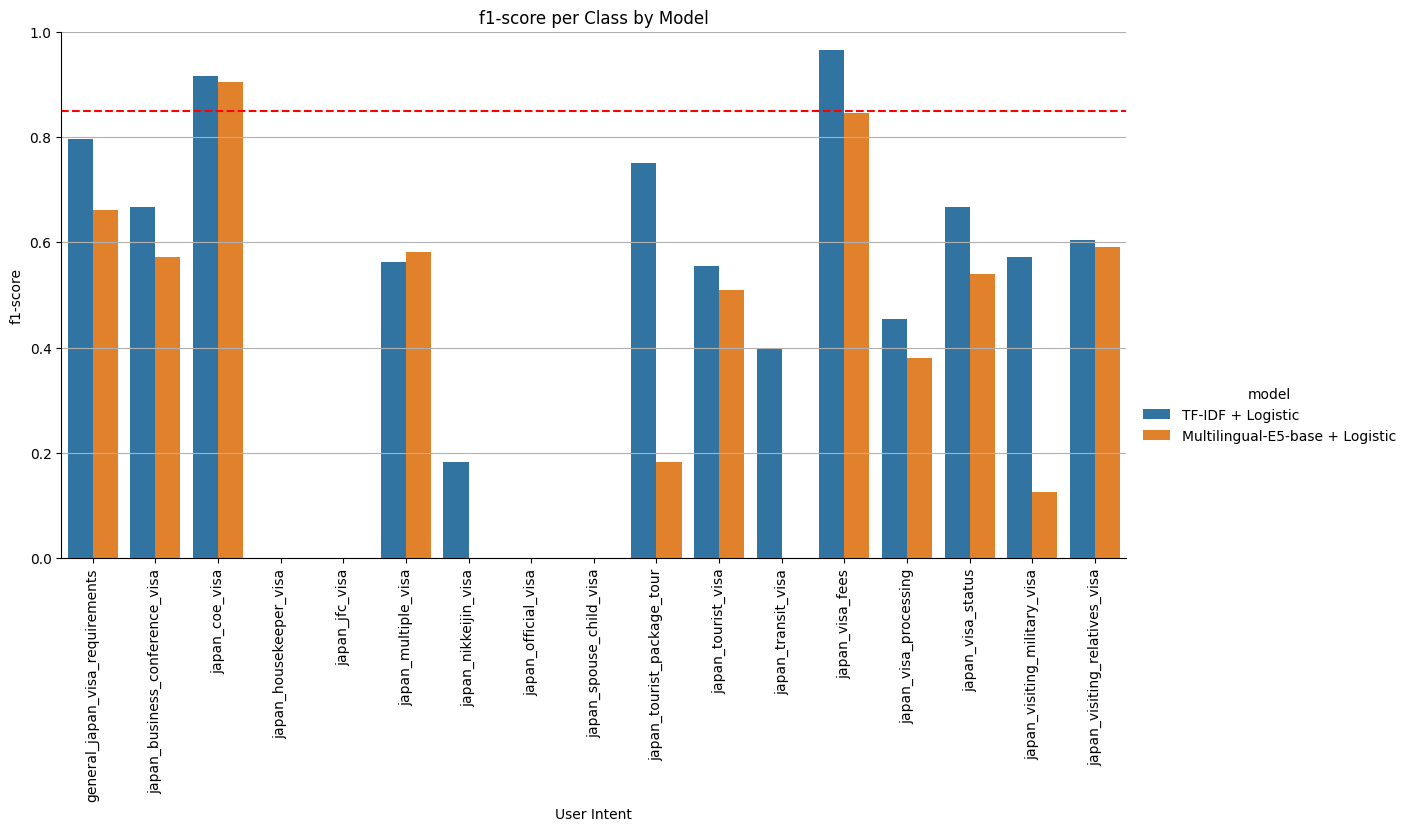

In [19]:
evaluate(models, X_test, y_test)

### 👀 Manual Evaluation with 6 questions

In [20]:
questions = [
    "ano ang mga requirments na need i submit for applying japan tourist visa?",
    "gaano katagal ang pag poprocess ng pag-aapply ng japan visa?",
    "gaano katagal ang validity ng japan visa?",
    "kailangan ba na lahat ng i susubmit na documents katulad ng psa ay original documents?",
    "kailangan ba ng parents consent kapag under age ang mag aapply ng visa?",
    "kapag bibisitahin ko ang mga relatives ko sa japan what kind of visa  ang kailangan ko?"
]

for model_name, model in models.items():
    print(f'[{model_name}]')
    answers = model.predict(questions)
    for idx, question in enumerate(questions):
        print(f'- {question}')
        print(f'intent: ({answers[idx]})')
        print()
    print()
    

[TF-IDF + Logistic]
- ano ang mga requirments na need i submit for applying japan tourist visa?
intent: (japan_tourist_visa)

- gaano katagal ang pag poprocess ng pag-aapply ng japan visa?
intent: (japan_visa_processing)

- gaano katagal ang validity ng japan visa?
intent: (japan_visa_processing)

- kailangan ba na lahat ng i susubmit na documents katulad ng psa ay original documents?
intent: (japan_tourist_visa)

- kailangan ba ng parents consent kapag under age ang mag aapply ng visa?
intent: (japan_multiple_visa)

- kapag bibisitahin ko ang mga relatives ko sa japan what kind of visa  ang kailangan ko?
intent: (japan_visiting_relatives_visa)


[Multilingual-E5-base + Logistic]
- ano ang mga requirments na need i submit for applying japan tourist visa?
intent: (general_japan_visa_requirements)

- gaano katagal ang pag poprocess ng pag-aapply ng japan visa?
intent: (japan_visa_processing)

- gaano katagal ang validity ng japan visa?
intent: (japan_visa_processing)

- kailangan ba na l

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### 🎛️ Hyperparameter Tuning

In [21]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform

# param_dist = {
#     'classifier__C': uniform(0.1, 10),
#     'classifier__penalty': ['l2'],
#     'classifier__solver': ['lbfgs', 'saga']
# }

# random_search_results = []
# for model in models:
#     grid = RandomizedSearchCV(model, param_dist, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1, n_iter=3)
#     grid.fit(X_train, y_train)
#     random_search_results.append(grid)

### Hyperparameter Tuning for Promising model (Best Model)

## 💾 Saving a Trained Intent Classifier

In [22]:
# import joblib

# # # 💾 Save model and vectorizer
# joblib.dump(grid.best_estimator_, "intent_classifier_pipeline.pkl")